In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from geospatial_plotting import REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var')


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_81201/1746632494.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('RdBu', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_81201/1746632494.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.08, 1, 1))


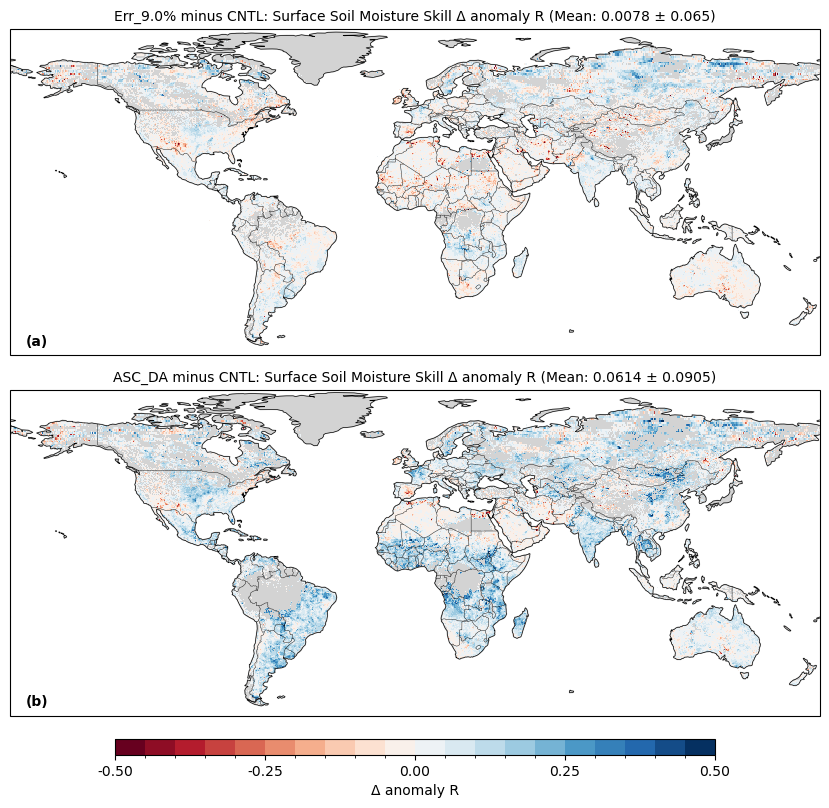

In [7]:
# Two-panel: Δ anomaly R (SMPL3 top, ASCL4 bottom) with discrete colorbars (pcolormesh)
paths = [
    (DATA_DIR / 'Rdiff_LS_DAv8_M36_obs_var_9_minus_LS_OLv8_M36.mat', 'Err_9.0% minus CNTL', '(a)'),
    #(DATA_DIR / 'Rdiff_LS_DAv8_M36_obs_var_64_minus_LS_OLv8_M36.mat', 'Err_6.4% minus CNTL', '(b)')
    ('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/DAv7_M36_MULTI_type_13_comb_fp_scaled/Rdiff_DAv7_M36_ASCAT_type_13_comb_fp_scaled_minus_OLv7_M36_MULTI_type_13_comb_fp_scaled.mat', 'ASC_DA minus CNTL', '(b)')
]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vmin, vmax = -0.5, 0.5
edges = np.linspace(vmin, vmax, 21)
cmap = get_cmap('RdBu', len(edges)-1)
norm = BoundaryNorm(edges, cmap.N)
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array = None
for ax, (path, title, lab) in zip(axes, paths):
    mat = sio.loadmat(path)
    rdiff = np.squeeze(mat['Rdiff_vector'])
    lons = np.squeeze(mat['lons'])
    lats = np.squeeze(mat['lats'])
    mean_val = np.nanmean(rdiff); std_val = np.nanstd(rdiff)
    if map_array is None:
        map_array = np.empty([len(lons), 3]); map_array.fill(np.nan)
        map_array[:,1] = lons; map_array[:,2] = lats
    map_array[:,0] = rdiff
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['global'], crs=ccrs.PlateCarree())
    ax.set_title(f'{title}: Surface Soil Moisture Skill Δ anomaly R (Mean: {mean_val:.3g} ± {std_val:.3g})', fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)

cax = fig.add_axes([0.25, 0.05, 0.50, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Δ anomaly R', fontsize=10)
cbar.set_ticks(edges[::5])
cbar.ax.set_xticklabels([f"{t:.2f}" for t in edges[::5]])
cbar.ax.tick_params(labelsize=10)
fig.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()


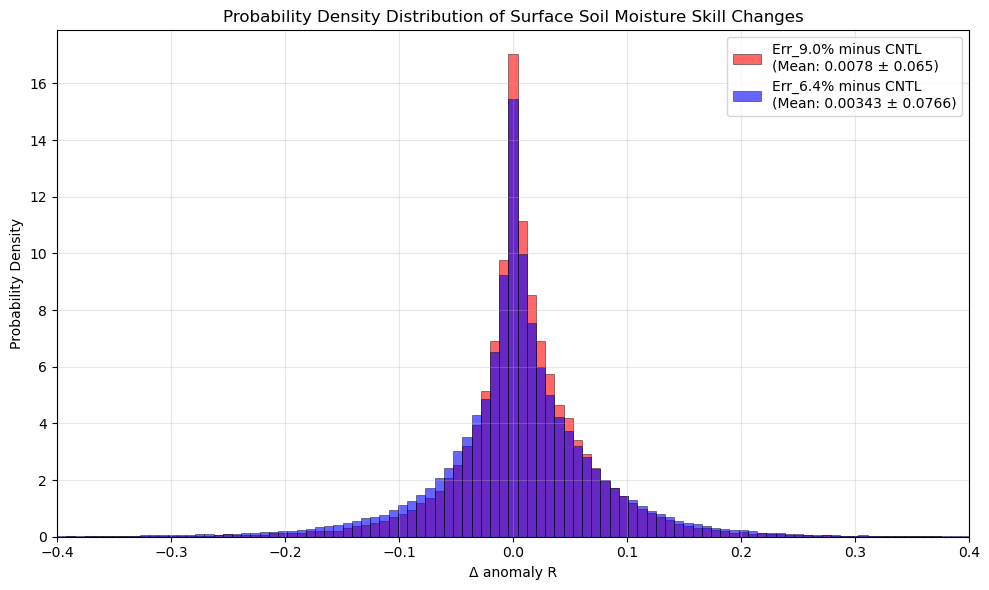

In [ ]:
# Create probability density histograms for comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Load and process both datasets for histograms
hist_data = []
labels = []

for path, title, _ in paths:
    mat = sio.loadmat(path)
    rdiff = np.squeeze(mat['Rdiff_vector'])
    # Remove NaN values for histogram
    rdiff_clean = rdiff[~np.isnan(rdiff)]
    hist_data.append(rdiff_clean)
    labels.append(title)

# Create overlapping histograms with probability density
bins = np.linspace(-0.4, 0.4, 100)
colors = ['red', 'blue']
alphas = [0.6, 0.6]

for i, (data, label, color, alpha) in enumerate(zip(hist_data, labels, colors, alphas)):
    ax.hist(data, bins=bins, density=True, alpha=alpha, color=color, 
            label=f'{label}\n(Mean: {np.mean(data):.3g} ± {np.std(data):.3g})', 
            edgecolor='black', linewidth=0.5)

ax.set_xlabel('Δ anomaly R')
ax.set_ylabel('Probability Density')
ax.set_title('Probability Density Distribution of Surface Soil Moisture Skill Changes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.4, 0.4)

plt.tight_layout()
plt.show()